In [2]:
import io
import os
import time
from datetime import datetime
from pathlib import Path
from typing import Iterable

from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types import FileObject
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.messages import MessageFile
from PIL import Image

In [3]:
load_dotenv()
api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
api_version = os.getenv("OPENAI_VERSION")
api_deployment_name = os.getenv("OPENAI_GPT_DEPLOYMENT")
email_URI = os.getenv("EMAIL_URI")

In [4]:
client = AzureOpenAI(api_key=api_key, api_version=api_version, azure_endpoint=api_endpoint)

tools_list = [
    {"type": "code_interpreter"},
]

In [5]:
DATA_FOLDER = "./data/banking/"


def upload_file(client: AzureOpenAI, path: str) -> FileObject:
    with Path(path).open("rb") as f:
        return client.files.create(file=f, purpose="assistants")


arr = os.listdir(DATA_FOLDER)
assistant_files = []
for file in arr:
    filePath = DATA_FOLDER + file
    assistant_files.append(upload_file(client, filePath))

file_ids = [file.id for file in assistant_files]

In [6]:
assistant = client.beta.assistants.create(
    name="Failed Banks Assistant",
    instructions="You are an assistant that can help find information about failed banks. "
    + "Use the provided file only.",
    tools=tools_list,
    model=api_deployment_name,
    file_ids=file_ids,
)

thread = client.beta.threads.create()

In [7]:
def format_messages(messages: Iterable[MessageFile]) -> None:
    message_list = []

    # Get all the messages till the last user message
    for message in messages:
        message_list.append(message)
        if message.role == "user":
            break

    # Reverse the messages to show the last user message first
    message_list.reverse()

    # Print the user or Assistant messages or images
    for message in message_list:
        for item in message.content:
            # Determine the content type
            if isinstance(item, MessageContentText):
                print(f"{message.role}:\n{item.text.value}\n")
            elif isinstance(item, MessageContentImageFile):
                # Retrieve image from file id
                response_content = client.files.content(item.image_file.file_id)
                data_in_bytes = response_content.read()
                # Convert bytes to image
                readable_buffer = io.BytesIO(data_in_bytes)
                image = Image.open(readable_buffer)
                # Resize image to fit in terminal
                width, height = image.size
                image = image.resize((width // 2, height // 2), Image.LANCZOS)
                # Display image
                image.show()

In [8]:
def process_message(content: str) -> None:
    client.beta.threads.messages.create(thread_id=thread.id, role="user", content=content)

    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions="The current date and time is: " + datetime.now().strftime("%x %X") + ".",
    )

    print("processing...")
    while True:
        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        if run.status == "completed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            break
        if run.status == "failed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            # Handle failed
            break
        if run.status == "expired":
            # Handle expired
            break
        if run.status == "cancelled":
            # Handle cancelled
            break
        if run.status == "requires_action":
            pass
        else:
            # print("in progress...",run.status)
            time.sleep(5)

processing...
user:
Create a chart of failed banks by state.

assistant:
To create a chart of failed banks by state, I first need to inspect the contents of the uploaded file to understand the data structure and identify the relevant fields that indicate the bank's state and failure status. Let's start by taking a look at the file that you have uploaded.

assistant:
The data has been successfully loaded. The relevant columns for creating a chart of failed banks by state appear to be `State ` for the state in which the bank was located and the columns that indicate the bank's failure, which could be inferred from the `Closing Date ` or the mere presence of the bank in this dataset (assuming the dataset lists only failed banks).

Now, let's proceed to aggregate the data by state and count the number of failed banks in each state. After that, we can create a chart to visualize this information.



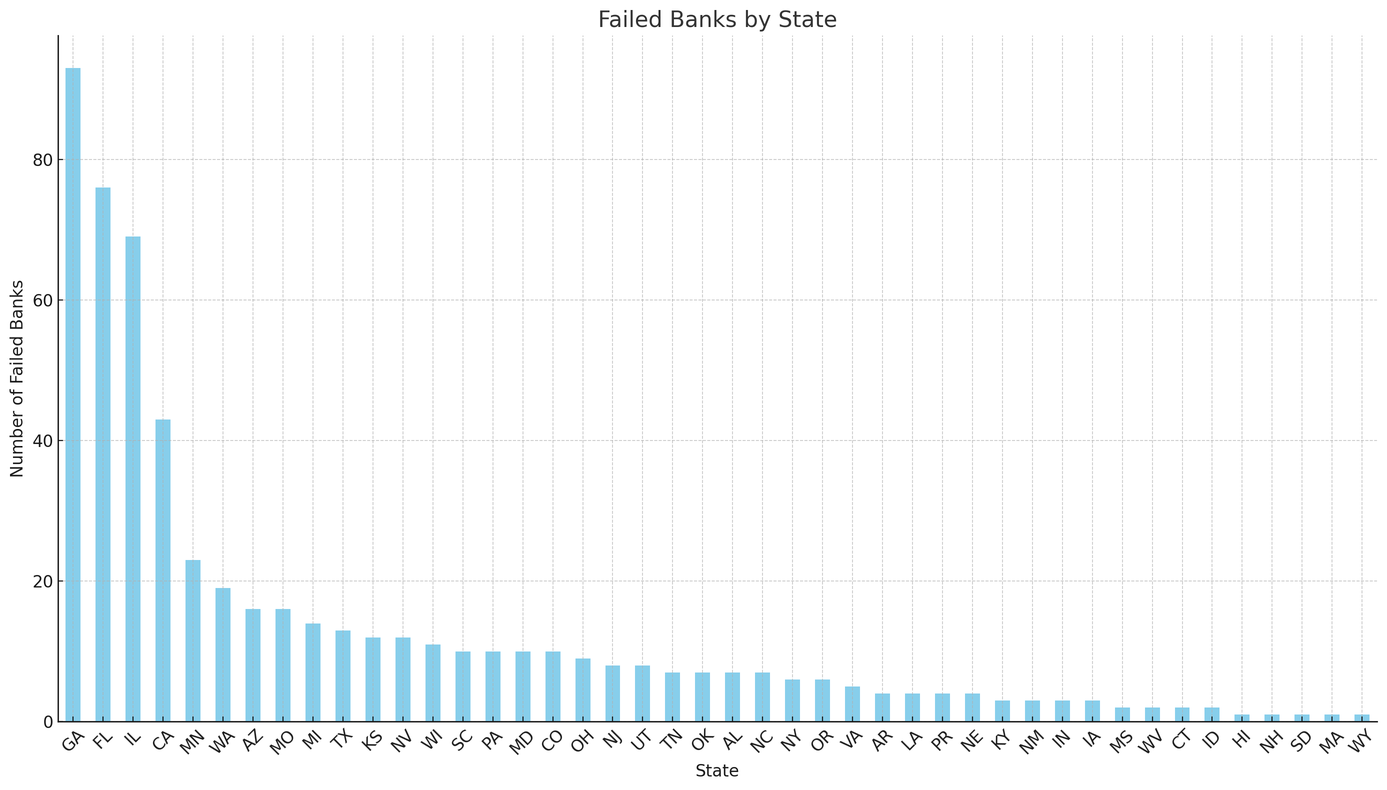

assistant:
Here is the bar chart visualizing the number of failed banks by state. Each bar represents a state, and the height of the bar indicates the total number of failed banks within that state. If you need any further analysis or another type of chart, please let me know!



In [9]:
process_message("Create a chart of failed banks by state.")

In [10]:
process_message("What was the last bank to fail?")

processing...
user:
What was the last bank to fail?

assistant:
To determine the last bank to fail, I will sort the data by the "Closing Date" column and retrieve the information for the bank with the most recent closing date. Let's do that now.

assistant:
The last bank to fail was Citizens Bank, which was located in Sac City, Iowa. The details are as follows:

- Bank Name: Citizens Bank
- City: Sac City
- State: Iowa (IA)
- Certificate Number (Cert): 8758
- Acquiring Institution: Iowa Trust & Savings Bank
- Closing Date: November 3, 2023
- FDIC Fund number associated with the takeover: 10545

If you need more information or further assistance, please let me know!



In [11]:
process_message("Which state has the most bank failures?")

processing...
user:
Which state has the most bank failures?

assistant:
The state with the most bank failures is Georgia (GA), with a total of 93 failed banks. If you have any other questions or need further analysis, feel free to ask!



In [12]:
process_message("Which banks failed in Florida in between 2020-2023?")

processing...
user:
Which banks failed in Florida in between 2020-2023?

assistant:
Between 2020 and 2023, the following bank failed in Florida:

- Bank Name: First City Bank of Florida
- City: Fort Walton Beach
- Closing Date: October 16, 2020

That is the only bank listed in the data as having failed in Florida during the specified time frame. If you need more information or further assistance, please let me know!



In [13]:
client.beta.assistants.delete(assistant.id)
client.beta.threads.delete(thread.id)
for file in assistant_files:
    client.files.delete(file.id)